In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/3574/1*1lL4r92AogT4_2VfFCfo9Q.jpeg")

In [4]:
!pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 660.6 kB/s eta 0:00:59
   ---------------------------------------- 0.4/38.8 MB 4.6 MB/s eta 0:00:09
    --------------------------------------- 0.7/38.8 MB 6.7 MB/s eta 0:00:06
    --------------------------------------- 0.9/38.8 MB 5.9 MB/s eta 0:00:07
   - -------------------------------------- 1.1/38.8 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.1/38.8 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.1/38.8 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.7/38.8 MB 4.8 MB/s eta 0:00:08
   - -------------------------------------- 1.9/38.8 MB 4.5 MB/s eta 0:00:09
   -- ------------------------------------- 2.0/38.8 MB 4.4 MB/s eta 0:00:09
   -- ------------------------------------- 2.1/38.8 MB 4.5 MB/s eta 0:00:09
   -- ------------------------------------- 2.1/38.8 MB 4.5 MB/s eta 0:00:09
   -

In [6]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import threading
import urllib
import cv2
import time
from sklearn.model_selection import train_test_split

from collections import Counter

import os

In [8]:
def check_size(url):
    r = requests.get(url, stream=True)
    return int(r.headers['Content-Length'])

def download_file(url, filename, bar=True):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    try:
        chunkSize = 1024
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            if bar:
                pbar = tqdm( unit="B", total=int( r.headers['Content-Length'] ) )
            for chunk in r.iter_content(chunk_size=chunkSize): 
                if chunk: # filter out keep-alive new chunks
                    if bar: 
                        pbar.update (len(chunk))
                    f.write(chunk)
        return filename
    except Exception as e:
        print(e)
        return
    
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(foo,(128, 128), interpolation=cv2.INTER_AREA)
        return foo
    except:
        return np.array([])

In [29]:
NUM_THRESHOLD = 25

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))

Total number of valid classes: 70
Total number of valid examples: 3740


Total number of valid examples: 3740
['https://upload.wikimedia.org/wikipedia/commons/5/58/Flickr_-_Gaspa_-_Giza%2C_la_piramide_grande.jpg', 'https://upload.wikimedia.org/wikipedia/commons/a/ac/Cheops_Pyramid_%284314345022%29.jpg', 'https://upload.wikimedia.org/wikipedia/commons/6/6d/Great_Pyramid_%282347859542%29.jpg', 'https://upload.wikimedia.org/wikipedia/commons/a/ac/Great_Pyramid_of_Giza_-_20080716a.jpg', 'https://upload.wikimedia.org/wikipedia/commons/d/dd/%D8%A7%D9%84%D9%87%D8%B1%D9%85_%D8%A7%D9%84%D8%A3%D9%88%D8%B3%D8%B7.jpg', 'https://upload.wikimedia.org/wikipedia/commons/d/db/Great_Pyramid_of_Giza%2C_Kheops_004.JPG', 'https://upload.wikimedia.org/wikipedia/commons/a/ad/AIDAdiva_Kreuzfahrt_Mittelmeer_2012_%28137%29.jpg', 'https://upload.wikimedia.org/wikipedia/commons/c/c9/Great_Pyramid_of_Giza_May_2015.JPG', 'https://upload.wikimedia.org/wikipedia/commons/f/f7/Aegypten1959-090_hg.jpg', 'http://upload.wikimedia.org/wikipedia/commons/1/10/Giza_Pyramid_of_Cheops.JPG', 'https:/

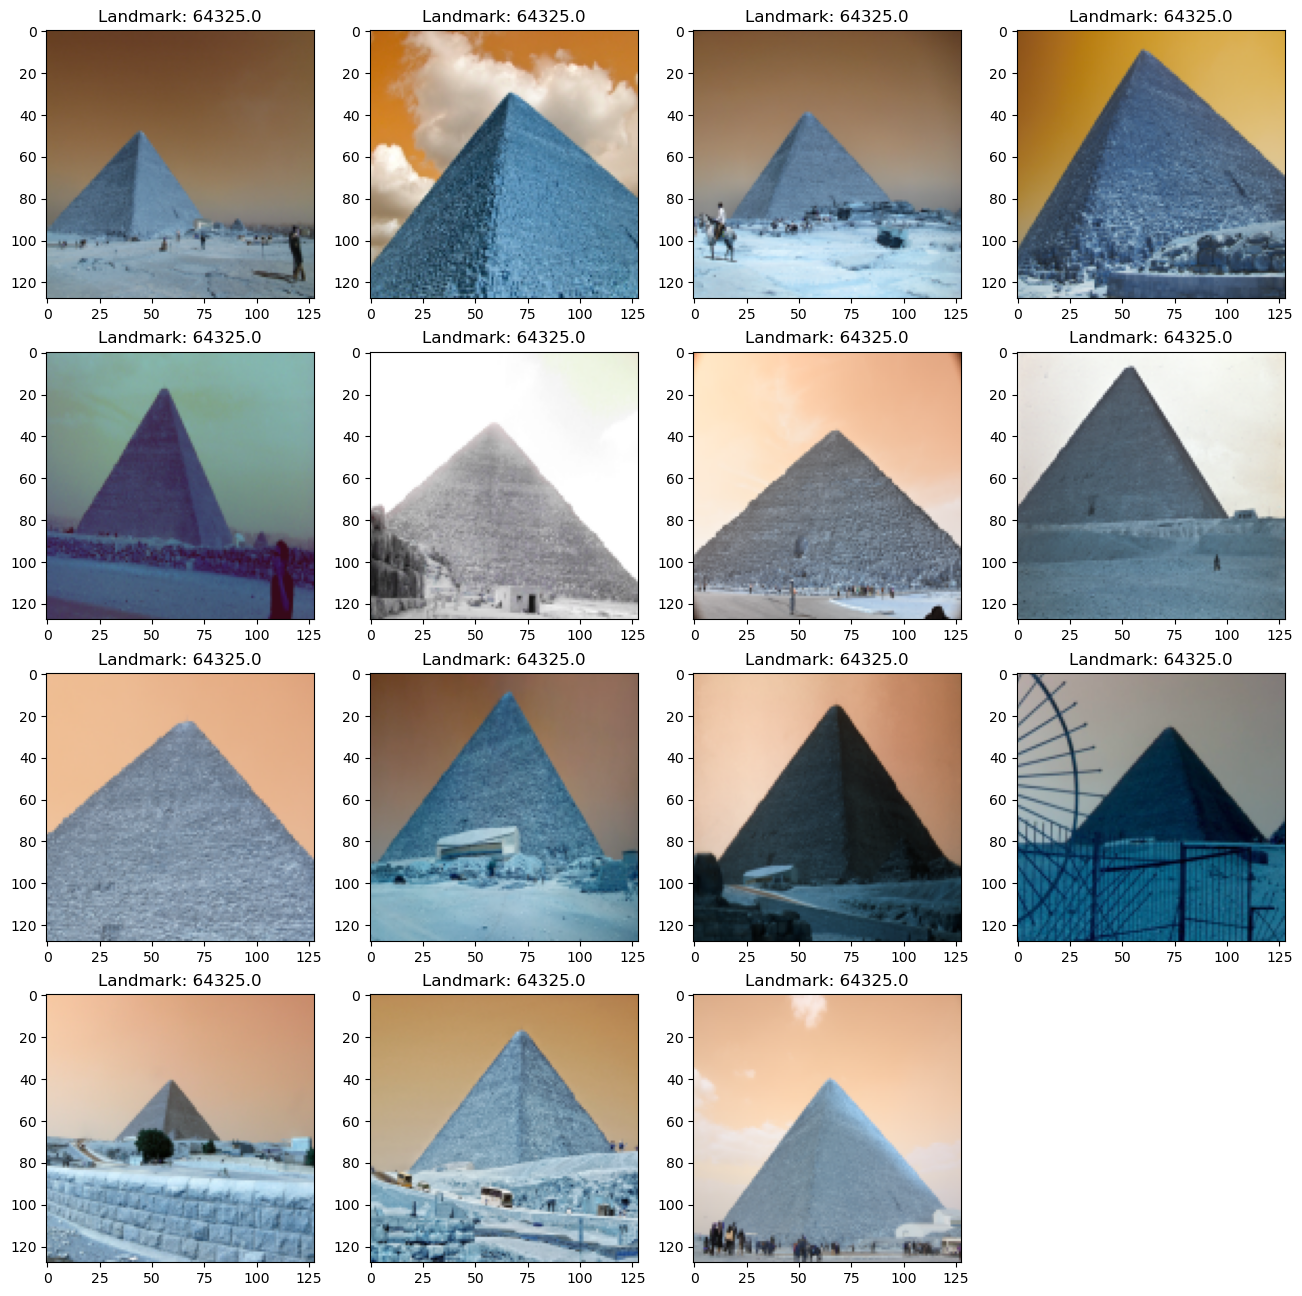

In [35]:


# Prepare mappings from landmark to index
i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

# Preparing valid URLs
all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()

valid_urls_dict = {x[0].split("/")[-1]: landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print(f"Total number of valid examples: {NUM_EXAMPLES}")

# Debugging: Check first few URLs to verify
print(valid_urls_list[:16])

# Function to download image using OpenCV (for processing)
def download_image_cv2_urllib(url):
    """
    Downloads image from URL and processes it (resizes to 128x128).
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        if foo.size != 0:
            foo = cv2.resize(foo, (128, 128), interpolation=cv2.INTER_AREA)
            return foo
        else:
            print(f"Failed to decode image: {url}")
            return np.array([])  # Return empty array if image decoding fails
    except Exception as e:
        print(f"Error downloading or processing image: {e}")
        return np.array([])

# Plotting the images
w = 20
h = 20
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
i = 1

# Iterate over the first 16 valid URLs
for url in valid_urls_list[:16]:
    print(f"Downloading image: {url}")  # Debugging: print the URL
    im = download_image_cv2_urllib(url)
    
    # Check if the image is valid and add it to the plot
    if im.size != 0:
        fig.add_subplot(rows, columns, i)
        title = f"Landmark: {idx_to_landmark[valid_urls_dict[url.split('/')[-1]]]}"
        plt.title(title)
        plt.imshow(im)
        i += 1
    else:
        print(f"Failed to download or empty image: {url}")  # Debugging: print failed images

# Show the final plot
plt.show()


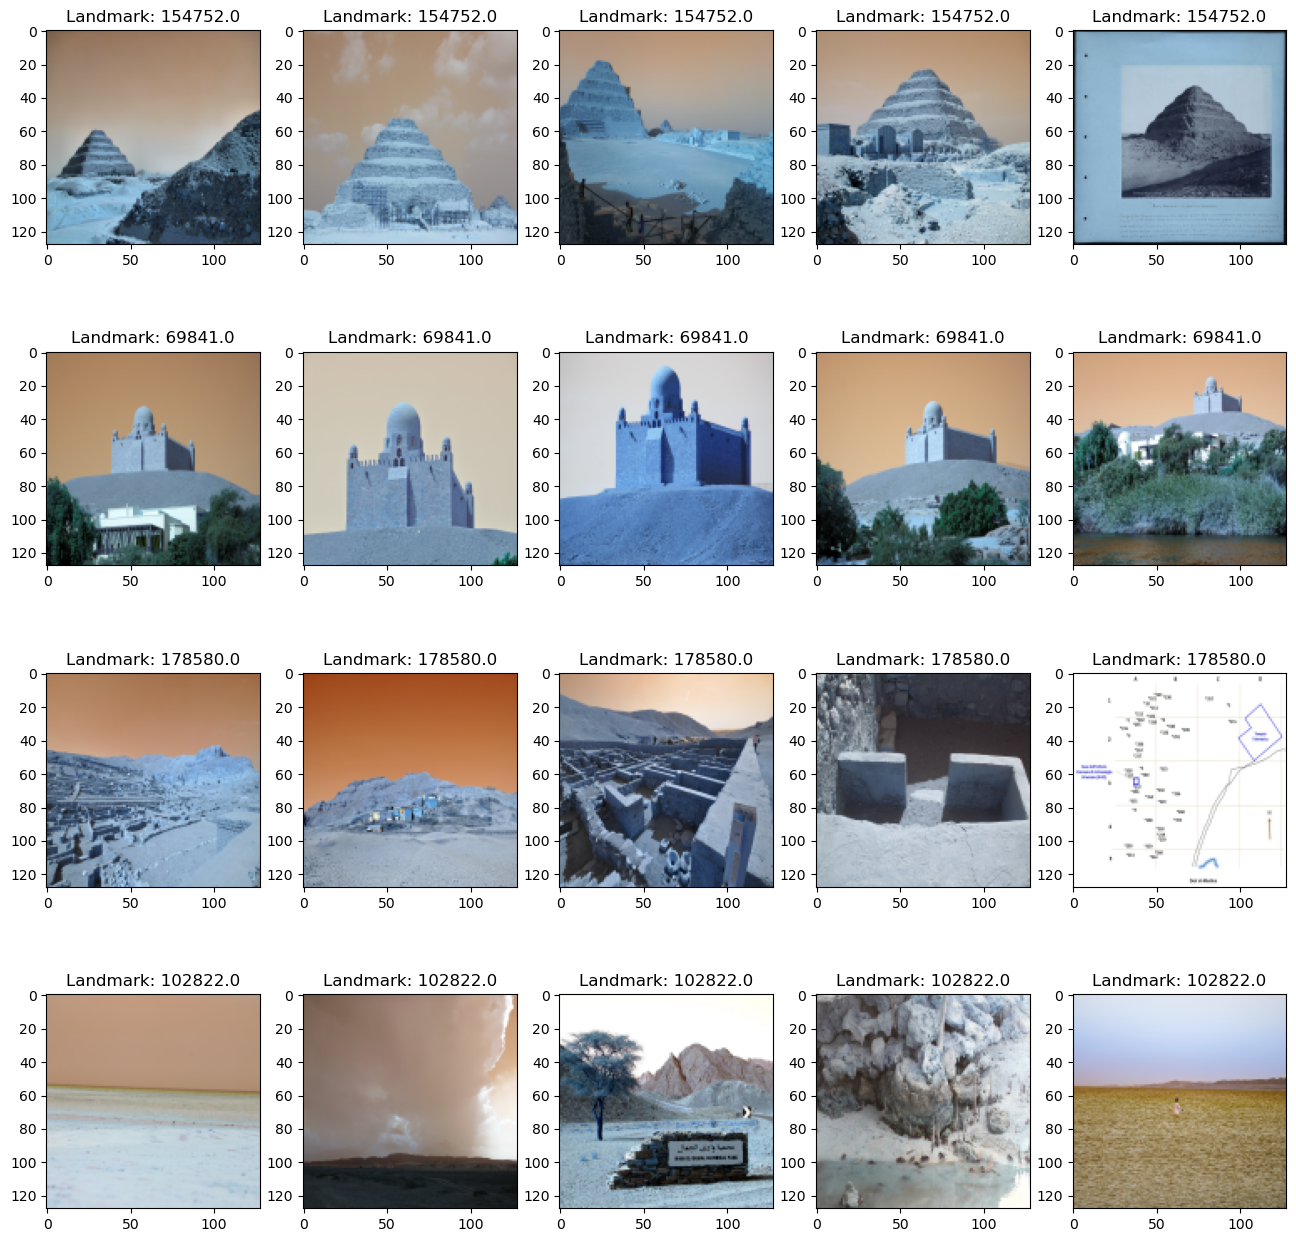

In [40]:
import random
import matplotlib.pyplot as plt

# Define the number of rows and columns for the plot
w = 20
h = 20
fig = plt.figure(figsize=(16, 16))
columns = 5
rows = 4

# Randomly sample landmarks from idx_to_landmark
landmarks = random.sample(idx_to_landmark, rows)

# Iterate over the sampled landmarks
for i in range(rows):
    landmark = landmarks[i]
    
    # Find all URLs for the current landmark
    urls = [x[0] for x in zip(all_urls, all_landmarks) if x[1] == landmark]
    
    # Check if there are enough images for the current landmark
    if len(urls) < columns:
        print(f"Warning: Not enough images for landmark {landmark}. Found {len(urls)} images.")
    
    # Iterate over the number of columns
    for j in range(min(columns, len(urls))):  # Ensure we do not exceed the available images
        im = download_image_cv2_urllib(urls[j])
        
        if im.size != 0:
            fig.add_subplot(rows, columns, i * columns + j + 1)
            plt.title(f"Landmark: {landmark}")
            plt.imshow(im)
        else:
            print(f"Failed to download image for {landmark} at index {j+1}")

# Show the final plot
plt.show()


In [42]:
train.head()

,gldv2_id,url,landmark_id,name
0,a2c2490adcd9361d,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
1,a38c385bf41aaff3,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
2,790ac011ae5178ec,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
3,8d11015559f719c9,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
4,330cb83786026637,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)


In [44]:
train_data = train.copy()

In [58]:
print(train_data.columns)


Index(['gldv2_id', 'url', 'landmark_id', 'name'], dtype='object')


In [69]:
# Check the column names in your DataFrame
print(train_data.columns)

# Then access the data using the correct column name
temp = 444
print('id', train_data['gldv2_id'][temp])  # Make sure 'id' is a valid column
print('url:', train_data['url'][temp])
print('landmark id:', train_data['landmark_id'][temp])


Index(['gldv2_id', 'url', 'landmark_id', 'name'], dtype='object')
id 55262dbfb2c057b0
url: https://upload.wikimedia.org/wikipedia/commons/a/a5/Elephantine_Island_by_Hatem_Moushir_18.JPG
landmark id: 81351.0


<Axes: >

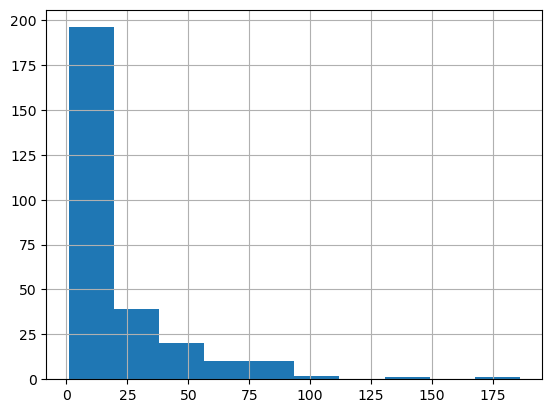

In [71]:
train_data['landmark_id'].value_counts().hist()

In [73]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
gldv2_id,0,0.0
url,0,0.0
landmark_id,0,0.0
name,0,0.0


In [79]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()
#this help is cleaning a data 

,Total,Percent
gldv2_id,0,0.0
url,0,0.0
landmark_id,0,0.0
name,0,0.0


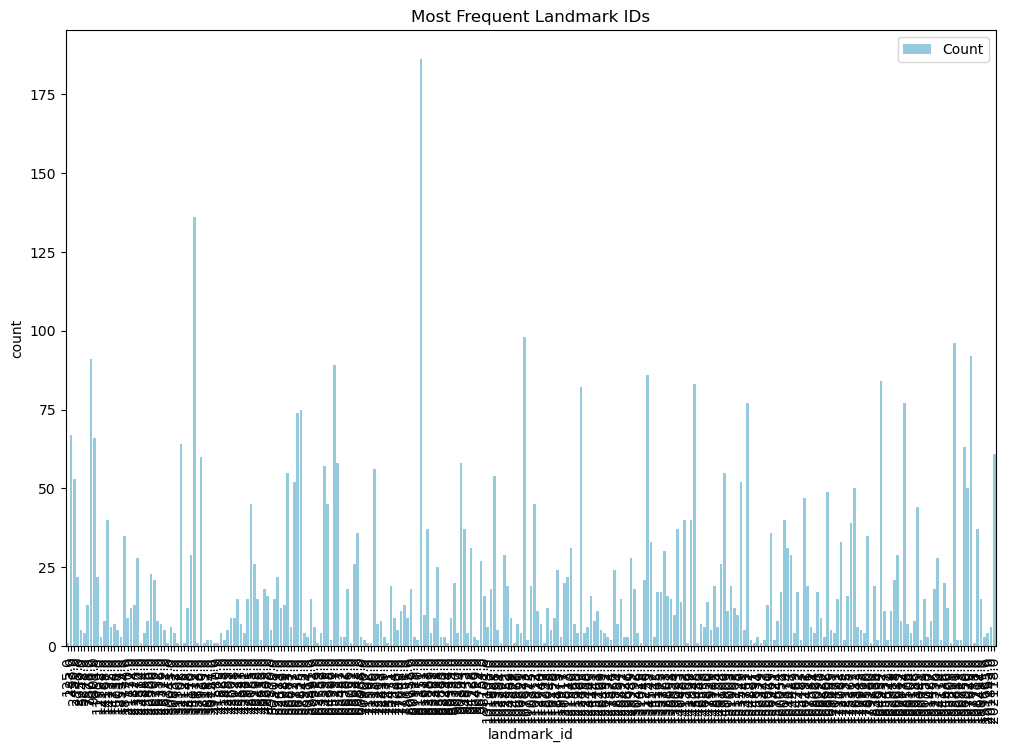

In [87]:
# Step 1: Count occurrences of each 'landmark_id'
landmark_counts = train_data['landmark_id'].value_counts()

# Step 2: Convert counts to a DataFrame for better manipulation and plotting
landmark_counts_df = landmark_counts.reset_index()
landmark_counts_df.columns = ['landmark_id', 'count']

# Step 3: Sort by 'count' in descending order
landmark_counts_df = landmark_counts_df.sort_values(by='count', ascending=False)

# Step 4: Plot the graph
plt.figure(figsize=(12, 8))  # Set the figure size
plt.title('Most Frequent Landmark IDs')  # Set the title of the plot

# Step 5: Plot the barplot using Seaborn
sns.barplot(x="landmark_id", y="count", data=landmark_counts_df, label="Count", color="skyblue")

# Show the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()


In [7]:
import pandas as pd
train_data = pd.read_csv(r"C:\Users\AKSHAY KUMAR\Desktop\landmark_detection\gldv2_info.csv")


temp = pd.DataFrame(train_data.landmark_id.value_counts().head(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id', 'count']
temp


,landmark_id,count
0,81351.0,186
1,35012.0,136
2,107673.0,98
3,195811.0,96
4,197645.0,92
5,7666.0,91
6,65297.0,89
7,131755.0,86


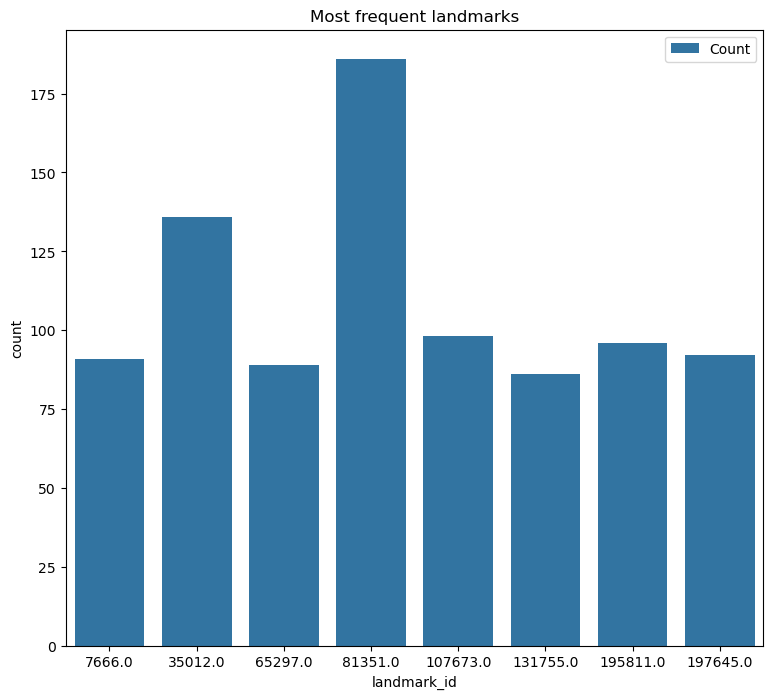

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 8))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp, label="Count")
plt.show()


In [13]:
temp = pd.DataFrame(train_data.landmark_id.value_counts().tail(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,88444.0,1
1,39747.0,1
2,35373.0,1
3,115293.0,1
4,41580.0,1
5,31307.0,1
6,71592.0,1
7,62739.0,1


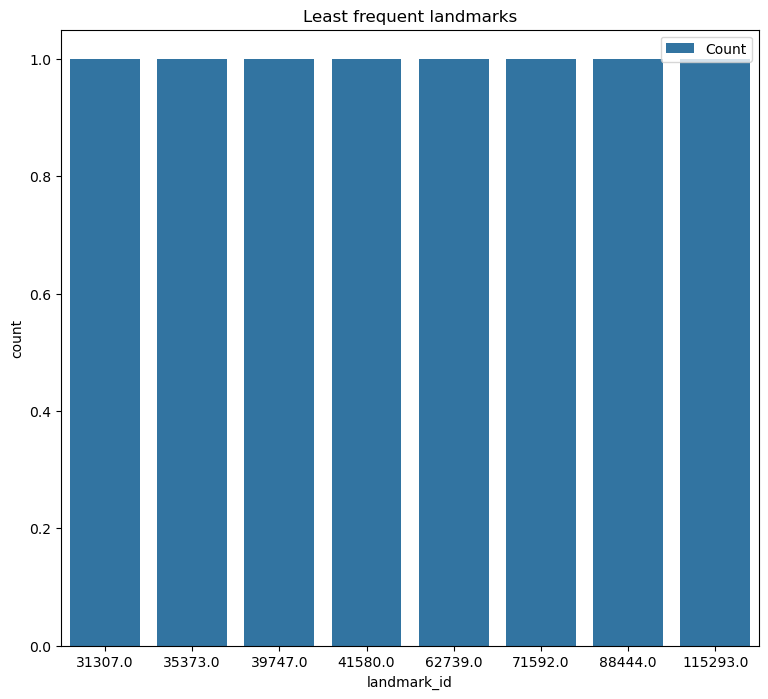

In [15]:
plt.figure(figsize = (9, 8))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

C:\Users\AKSHAY KUMAR\AppData\Local\Temp\ipykernel_15488\2680844279.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['landmark_id'])


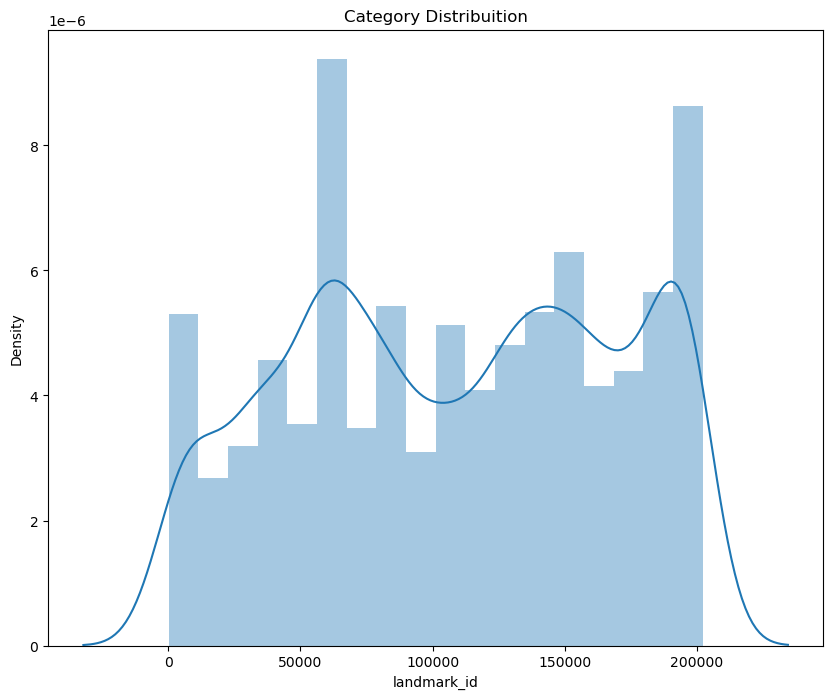

In [17]:
plt.figure(figsize = (10, 8))
plt.title('Category Distribuition')
sns.distplot(train_data['landmark_id'])

plt.show()

In [19]:
print("Number of classes under 20 occurences",(train_data['landmark_id'].value_counts() <= 20).sum(),'out of total number of categories',len(train_data['landmark_id'].unique()))

Number of classes under 20 occurences 199 out of total number of categories 279


In [21]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls, category_name):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])

    display(HTML(images_list))

print("Training data size",train_data.shape)
train_data.head(8)

Training data size (5414, 4)


,gldv2_id,url,landmark_id,name
0,a2c2490adcd9361d,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
1,a38c385bf41aaff3,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
2,790ac011ae5178ec,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
3,8d11015559f719c9,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
4,330cb83786026637,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
5,93385722c6155609,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
6,f50a10f1e28df7c3,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)
7,085c0bfbe60cd5df,https://upload.wikimedia.org/wikipedia/commons...,89384.0,Bab_al-Nasr_(Cairo)


In [33]:
temp = pd.DataFrame(train_data.name.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['name','count']
temp


,name,count
0,Elephantine,186
1,Siwa,136
2,Temple_of_Kom_Ombo,98
3,Great_Hypostyle_Hall_of_Karnak,96
4,Muizz_Street,92
...,...,...
274,Island_of_Bigeh,1
275,Pyramid_of_Qakare_Ibi,1
276,Pyramid_of_Baka,1
277,Rahmanyia_island,1


In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from urllib import request
from io import BytesIO
%matplotlib inline 

In [37]:
def displayLandmarkImages(urls):
    
    imageStyle = "height: 60px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(imagesList))
    
    
def displayLandmarkImagesLarge(urls):
    
    imageStyle = "height: 100px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(imagesList))

In [43]:
import pandas as pd
from IPython.display import display, HTML

# Ensure train is defined
train = train_data  # Assigning train_data to train if that's the intended DataFrame

# Constants
LANDMARK_NUMBER = 5
IMAGES_NUMBER = 5

# Function to display images
def displayLandmarkImagesLarge(urls):
    imageStyle = "height: 100px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.items()])
    display(HTML(imagesList))

# Verify the necessary columns
if 'landmark_id' in train.columns and 'url' in train.columns:
    landMarkIDs = pd.Series(train['landmark_id'].value_counts().keys())[1:LANDMARK_NUMBER+1]
    
    # Loop through the landmark IDs
    for landMarkID in landMarkIDs:
        url = train[train['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
        displayLandmarkImagesLarge(url)
else:
    print("The necessary columns 'landmark_id' or 'url' are missing from the DataFrame.")


C:\Users\AKSHAY KUMAR\AppData\Local\Temp\ipykernel_15488\3874744367.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['landmark_id'], color="tomato", shade=True)


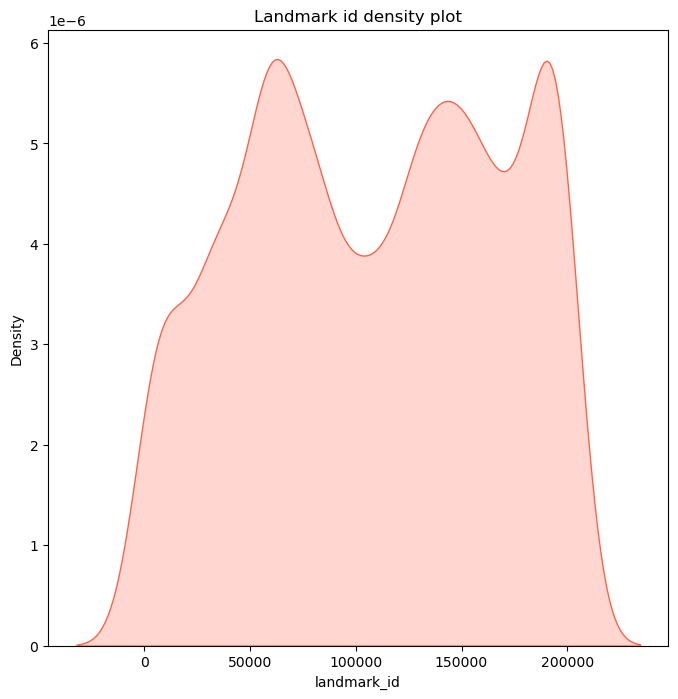

In [45]:
plt.figure(figsize = (8, 8))
plt.title('Landmark id density plot')
sns.kdeplot(train['landmark_id'], color="tomato", shade=True)
plt.show()

C:\Users\AKSHAY KUMAR\AppData\Local\Temp\ipykernel_15488\3528052336.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['landmark_id'],color='green', kde=True,bins=100)


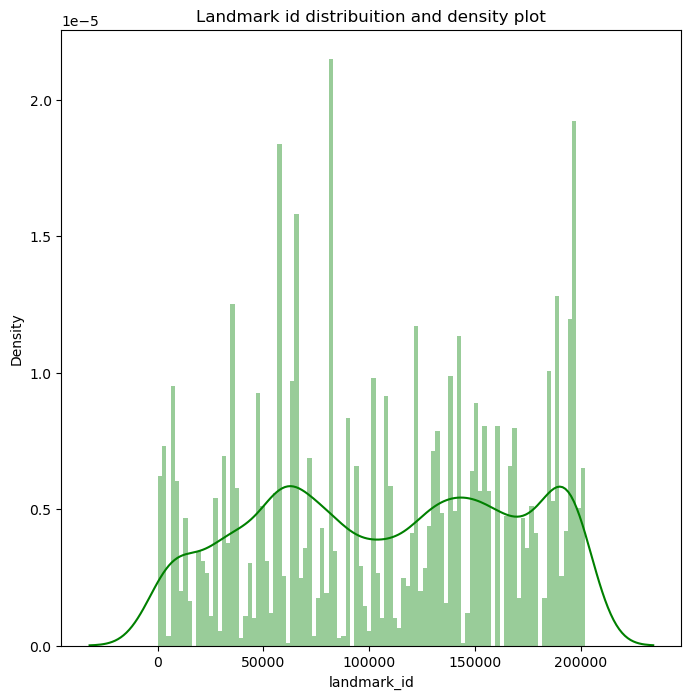

In [47]:
plt.figure(figsize = (8, 8))
plt.title('Landmark id distribuition and density plot')
sns.distplot(train['landmark_id'],color='green', kde=True,bins=100)
plt.show()

In [51]:
# Constants
IMAGES_NUMBER = 50
landmarkId = train['landmark_id'].value_counts().keys()[5]

# Get the URLs of the images for the specified landmarkId
urls = train[train['landmark_id'] == landmarkId]['url'].head(IMAGES_NUMBER)

# Define the function to display images
from IPython.display import display, HTML

def displayLandmarkImages(urls):
    imageStyle = "height: 60px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.items()])
    display(HTML(imagesList))

# Display the images
displayLandmarkImages(urls)


In [36]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Image directory and CSV file path
image_dir = r"C:\Users\AKSHAY KUMAR\Desktop\landmark_detection\images"
csv_file = r"C:\Users\AKSHAY KUMAR\Desktop\landmark_detection\gldv2_info.csv"

# Load the CSV to get image filenames and labels
df = pd.read_csv(csv_file)

# Ensure column names are clean
df.columns = df.columns.str.strip()

# Check for column names
if 'name' not in df.columns or 'gldv2_id' not in df.columns:
    print("Error: CSV file must contain 'name' and 'gldv2_id' columns.")
else:
    # Initialize lists to store labels and images
    labels = []
    images = []

    # Create a dictionary from the CSV for easier label lookup (image_name -> label)
    image_label_dict = {row['name']: row['gldv2_id'] for _, row in df.iterrows()}

    # Debugging: Print first few rows of the dataframe to check
    print(df.head())

    # Process each image in the image directory
    image_count = 0
    for file in os.listdir(image_dir):
        if file.endswith('.jpg') or file.endswith('.png'):  # Ensure only images are processed
            # Ensure the file is in the CSV (i.e., image exists in the CSV file)
            if file in image_label_dict:
                img_path = os.path.join(image_dir, file)  # Properly joining the directory and file name
                img = cv2.imread(img_path)
                
                if img is None:
                    print(f"Warning: Unable to read image at {img_path}. Skipping...")
                    continue  # Skip this image if it couldn't be loaded

                # Resize the image to 224x224
                img_resized = cv2.resize(img, (224, 224))  
                images.append(img_resized)
                labels.append(image_label_dict[file])  # Assign label from the dictionary
                image_count += 1

    # Check if any images were loaded
    if image_count == 0:
        print("No images were loaded. Please check the image directory and CSV file.")
    else:
        print(f"Loaded {image_count} images.")

    # Convert to numpy arrays
    images = np.array(images) / 255.0  # Normalize the images
    labels = np.array(labels)

    # If labels are categorical (e.g., string labels), encode them into numeric values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Split dataset if images are not empty
    if images.shape[0] > 0:
        X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
        print("Training set size:", len(X_train))
        print("Validation set size:", len(X_val))
    else:
        print("No images available for splitting.")


           gldv2_id                                                url  \
0  a2c2490adcd9361d  https://upload.wikimedia.org/wikipedia/commons...   
1  a38c385bf41aaff3  https://upload.wikimedia.org/wikipedia/commons...   
2  790ac011ae5178ec  https://upload.wikimedia.org/wikipedia/commons...   
3  8d11015559f719c9  https://upload.wikimedia.org/wikipedia/commons...   
4  330cb83786026637  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id                 name  
0      89384.0  Bab_al-Nasr_(Cairo)  
1      89384.0  Bab_al-Nasr_(Cairo)  
2      89384.0  Bab_al-Nasr_(Cairo)  
3      89384.0  Bab_al-Nasr_(Cairo)  
4      89384.0  Bab_al-Nasr_(Cairo)  
No images were loaded. Please check the image directory and CSV file.
No images available for splitting.


In [38]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Image directory and CSV file path
image_dir = r"C:\Users\AKSHAY KUMAR\Desktop\landmark_detection\images"
csv_file = r"C:\Users\AKSHAY KUMAR\Desktop\landmark_detection\gldv2_info.csv"

# Load the CSV to get image filenames and labels
df = pd.read_csv(csv_file)

# Ensure column names are clean
df.columns = df.columns.str.strip()

# Check for column names
if 'name' not in df.columns or 'gldv2_id' not in df.columns:
    print("Error: CSV file must contain 'name' and 'gldv2_id' columns.")
else:
    # Initialize lists to store labels and images
    labels = []
    images = []

    # Create a dictionary from the CSV for easier label lookup (image_name -> label)
    image_label_dict = {row['name']: row['gldv2_id'] for _, row in df.iterrows()}

    # Debugging: Print first few rows of the dataframe to check
    print("First few rows of the CSV:\n", df.head())

    # List the files in the image directory
    print("Files in the image directory:")
    image_files = os.listdir(image_dir)
    print(image_files)

    # Process each image in the image directory
    image_count = 0
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.png'):  # Ensure only images are processed
            # Ensure the file is in the CSV (i.e., image exists in the CSV file)
            if file in image_label_dict:
                img_path = os.path.join(image_dir, file)  # Properly joining the directory and file name
                img = cv2.imread(img_path)
                
                if img is None:
                    print(f"Warning: Unable to read image at {img_path}. Skipping...")
                    continue  # Skip this image if it couldn't be loaded

                # Resize the image to 224x224
                img_resized = cv2.resize(img, (224, 224))  
                images.append(img_resized)
                labels.append(image_label_dict[file])  # Assign label from the dictionary
                image_count += 1
            else:
                print(f"File {file} not found in CSV.")

    # Check if any images were loaded
    if image_count == 0:
        print("No images were loaded. Please check the image directory and CSV file.")
    else:
        print(f"Loaded {image_count} images.")

    # Convert to numpy arrays
    images = np.array(images) / 255.0  # Normalize the images
    labels = np.array(labels)

    # If labels are categorical (e.g., string labels), encode them into numeric values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Split dataset if images are not empty
    if images.shape[0] > 0:
        X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
        print("Training set size:", len(X_train))
        print("Validation set size:", len(X_val))
    else:
        print("No images available for splitting.")


First few rows of the CSV:
            gldv2_id                                                url  \
0  a2c2490adcd9361d  https://upload.wikimedia.org/wikipedia/commons...   
1  a38c385bf41aaff3  https://upload.wikimedia.org/wikipedia/commons...   
2  790ac011ae5178ec  https://upload.wikimedia.org/wikipedia/commons...   
3  8d11015559f719c9  https://upload.wikimedia.org/wikipedia/commons...   
4  330cb83786026637  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id                 name  
0      89384.0  Bab_al-Nasr_(Cairo)  
1      89384.0  Bab_al-Nasr_(Cairo)  
2      89384.0  Bab_al-Nasr_(Cairo)  
3      89384.0  Bab_al-Nasr_(Cairo)  
4      89384.0  Bab_al-Nasr_(Cairo)  
Files in the image directory:
['6_October_Bridge', 'Abu_el-Abbas_el-Mursi_Mosque', 'Abu_Ghurab', 'Abu_Haggag_Mosque', 'Abu_Qir_Bay', 'Agiba_beach', 'Aguilkia_Island', 'Ahmed_Shawki_Museum', 'Al-Aqmar_Mosque', 'Al-Ashraf_Mosque', 'Al-Azhar_Park_(Cairo)', 'Al-Fath_Mosque', 'Al-Ghuri_Complex', 'Al-Jaw

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os

# Step 1: Load and preprocess the dataset
data_dir = r"C:\Users\AKSHAY KUMAR\Desktop\landmark_detection"  # Change this to your dataset path
batch_size = 32
img_size = (64, 64)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize and split dataset

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Training set
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Validation set
)

# Step 2: Define a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Update input shape
    MaxPooling2D(pool_size=(2, 2)),  # Pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Pooling layer
    Flatten(),  # Flatten output to feed into Dense layers
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Step 3: Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Step 4: Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Step 5: Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Found 4313 images belonging to 2 classes.
Found 1078 images belonging to 2 classes.


C:\Users\AKSHAY KUMAR\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 55s 384ms/step - accuracy: 0.9785 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 1.0000 - loss: 8.4888e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 1.0000 - loss: 9.6111e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 1.0000 - loss: 3.8129e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 1.0000 - loss: 9.6730e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 184ms/step - accuracy: 1.0000 - loss: 7.3764e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 1.0000 - loss: 1.9983e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
135/135 ━━━━━━━━━━━━